# Resumo do que foi feito
Neste case foi solicitado a criação de um novo modelo de *Credit Scoring* e poder classificar se um cliente é inadimplente ou não inadimplente. A partir disso, fiz todos os processos solicitados no e-mail:
1. Tratamento e Limpeza de Dados
2. Manipulação de Dados
3. Análise Exploratória
4. Feature Engineering
5. Construção de modelos de Machine Learning
6. Avaliação de Resultados do Modelo

O modelo criado por mim teve algumas caracteristicas de identificação como: 
* Personal Net Income inferior a R$ 1.500
* Idade inferior a 71 anos
* Tempo de residência inferior a 546 meses

Cheguei a essas conclusões devido ao ao processo de Análise exploratória, Manipulação dos dados e limpeza.
Ao final, obttive apenas 10 fetures e pouco mais de 36.000 linhas, em comparação com a base de dados original que continha: 29 features e 40.000 linhas.

Os modelo que interpretei como o melhor foi o Xgboost, após realizar o balanceamento da base de dados. Onde obtive uma precisão melhor e uma revocação maior também.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
dados = pd.read_csv("MutualClients.csv", index_col=False)

Visualizando os dados

In [ ]:
dados.head(10)

,Unnamed: 0,clientId,shopId,gender,maritalStatus,age,numberOfDependents,education,flagResidencialPhone,areaCodeResidencialPhone,bestPaymentDay,shopRank,residenceType,monthsInResidence,flagMothersName,flagFathersName,flagResidenceTown_WorkingTown,flagResidenceState_WorkingState,monthsInTheJob,professionCode,mateIncome,flagResidencialAddress_PostalAddress,flagOtherCard,quantityBankingAccounts,flagMobilePhone,flagContactPhone,personalNetIncome,codeApplicationBooth,BAD
0,1,2,15,F,S,18,0,NaN,Y,31,20,0,P,216,Y,Y,Y,Y,12,853,0.0,Y,N,0,N,N,300.0,0,0
1,2,4,12,F,C,47,0,NaN,N,31,25,0,P,180,Y,Y,N,Y,24,35,0.0,Y,N,0,N,N,304.0,0,0
2,3,5,16,F,S,28,0,NaN,Y,31,25,0,O,12,Y,Y,Y,Y,12,24,0.0,Y,N,0,N,N,250.0,0,0
3,4,6,24,M,S,26,0,NaN,N,31,28,0,P,180,Y,Y,N,Y,0,999,0.0,Y,N,0,N,N,800.0,0,0
4,5,7,55,F,S,22,0,NaN,Y,31,12,0,A,0,Y,Y,Y,Y,48,999,0.0,Y,N,0,N,N,410.0,0,0
5,6,8,6,F,C,21,0,NaN,Y,23,28,0,A,24,Y,Y,Y,Y,12,40,800.0,Y,N,0,N,N,248.0,0,0
6,7,9,3,F,S,27,0,NaN,Y,31,20,0,A,0,Y,Y,Y,Y,0,950,0.0,Y,N,0,N,N,1000.0,0,1
7,8,10,23,F,C,57,0,NaN,Y,31,12,0,P,24,Y,Y,N,Y,96,13,0.0,Y,N,0,N,N,856.0,0,0
8,9,11,25,F,S,53,0,NaN,Y,31,18,0,P,60,Y,Y,N,Y,24,13,0.0,Y,N,0,N,N,738.0,0,1
9,10,12,12,F,C,32,0,NaN,Y,31,12,0,P,24,Y,Y,N,Y,0,165,0.0,Y,N,0,N,N,700.0,0,0


Verificando se há valores vazios.

In [ ]:
dados.isnull().sum()

Unnamed: 0                                  0
clientId                                    0
shopId                                      0
gender                                      3
maritalStatus                               0
age                                         0
numberOfDependents                          0
education                               40000
flagResidencialPhone                        0
areaCodeResidencialPhone                    0
bestPaymentDay                              0
shopRank                                    0
residenceType                               0
monthsInResidence                           0
flagMothersName                             0
flagFathersName                             0
flagResidenceTown_WorkingTown               0
flagResidenceState_WorkingState             0
monthsInTheJob                              0
professionCode                              0
mateIncome                                  0
flagResidencialAddress_PostalAddre

Verificando a existência de dados duplicados

In [ ]:
dados.duplicated().sum() #Não há dados duplicados na base de dados

0

Analisando Dtype das colunas

In [ ]:
dados.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 29 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Unnamed: 0                            40000 non-null  int64  
 1   clientId                              40000 non-null  int64  
 2   shopId                                40000 non-null  int64  
 3   gender                                39997 non-null  object 
 4   maritalStatus                         40000 non-null  object 
 5   age                                   40000 non-null  int64  
 6   numberOfDependents                    40000 non-null  int64  
 7   education                             0 non-null      float64
 8   flagResidencialPhone                  40000 non-null  object 
 9   areaCodeResidencialPhone              40000 non-null  int64  
 10  bestPaymentDay                        40000 non-null  int64  
 11  shopRank       

Verificando a quantidade de clientes Inadimplentes e Não Inadimplentes

In [ ]:
dados['BAD'].value_counts()

0    32100
1     7900
Name: BAD, dtype: int64

# 1. Tratamento, Limpeza de Dados e Manipulação dos Dados

### No caso os dados já estão tratados. Ou seja, o tipo object, int64 e float64 estão bem adptados para o que cada coluna corresponde

Removendo as colunas de identificação de cliente, código de profissão e colunas NaN da base de dados. 

In [ ]:
clear_data = dados.drop(['Unnamed: 0', 'clientId', "shopId", "education", "professionCode"], axis=1)

In [ ]:
clear_data.head(10)

,gender,maritalStatus,age,numberOfDependents,flagResidencialPhone,areaCodeResidencialPhone,bestPaymentDay,shopRank,residenceType,monthsInResidence,flagMothersName,flagFathersName,flagResidenceTown_WorkingTown,flagResidenceState_WorkingState,monthsInTheJob,mateIncome,flagResidencialAddress_PostalAddress,flagOtherCard,quantityBankingAccounts,flagMobilePhone,flagContactPhone,personalNetIncome,codeApplicationBooth,BAD
0,F,S,18,0,Y,31,20,0,P,216,Y,Y,Y,Y,12,0.0,Y,N,0,N,N,300.0,0,0
1,F,C,47,0,N,31,25,0,P,180,Y,Y,N,Y,24,0.0,Y,N,0,N,N,304.0,0,0
2,F,S,28,0,Y,31,25,0,O,12,Y,Y,Y,Y,12,0.0,Y,N,0,N,N,250.0,0,0
3,M,S,26,0,N,31,28,0,P,180,Y,Y,N,Y,0,0.0,Y,N,0,N,N,800.0,0,0
4,F,S,22,0,Y,31,12,0,A,0,Y,Y,Y,Y,48,0.0,Y,N,0,N,N,410.0,0,0
5,F,C,21,0,Y,23,28,0,A,24,Y,Y,Y,Y,12,800.0,Y,N,0,N,N,248.0,0,0
6,F,S,27,0,Y,31,20,0,A,0,Y,Y,Y,Y,0,0.0,Y,N,0,N,N,1000.0,0,1
7,F,C,57,0,Y,31,12,0,P,24,Y,Y,N,Y,96,0.0,Y,N,0,N,N,856.0,0,0
8,F,S,53,0,Y,31,18,0,P,60,Y,Y,N,Y,24,0.0,Y,N,0,N,N,738.0,0,1
9,F,C,32,0,Y,31,12,0,P,24,Y,Y,N,Y,0,0.0,Y,N,0,N,N,700.0,0,0


### Dividindo a análise em variáveis qualitativas e quantitativas

In [ ]:
#Selecionando as variaveis categóricas e variaveis discretas/Continuas
clear_data.select_dtypes(include="object").describe()

,gender,maritalStatus,flagResidencialPhone,residenceType,flagMothersName,flagFathersName,flagResidenceTown_WorkingTown,flagResidenceState_WorkingState,flagResidencialAddress_PostalAddress,flagOtherCard,flagMobilePhone,flagContactPhone
count,39997,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000
unique,2,5,2,4,2,2,2,2,2,1,1,1
top,F,S,Y,P,Y,Y,N,Y,Y,N,N,N
freq,27903,20375,32649,29752,39850,38342,21740,39653,39158,40000,40000,40000


Avaliando as variáveis categóricas. É possível observar que as colunas:

1. flagResidencialAddress_PostalAddress
2. flagOtherCard
3. flagMobilePhone
4. flagContactPhone 
5. flagResidenceState_WorkingState
6. flagMothersName
7. flagFathersName

Todas possuem ou a mesma quantidade de repetições do mesmo rótulo, ou seja, Y ou N. ou pelo menos grande parte como nas colunas __flagResidencialAddress_PostalAddress,flagResidenceState_WorkingState,
flagMothersName e flagFathersName__ que contem uma contagem no valor de 20562, mas que a frequência de repetições do rótulo Y  praticamente 95% ou superior da contagem inteira. Além disso, a coluna __gender__ também apresenta uma pequena parte das linhas com valores NaN. Então, irei  analisar essas linhas para remover elas da minha análise. 

In [ ]:
clear_data = clear_data.drop(["flagResidencialAddress_PostalAddress",'flagOtherCard','flagMobilePhone','flagContactPhone','flagResidenceState_WorkingState','flagMothersName','flagFathersName'], axis=1)

In [ ]:
clear_data.head()

,gender,maritalStatus,age,numberOfDependents,flagResidencialPhone,areaCodeResidencialPhone,bestPaymentDay,shopRank,residenceType,monthsInResidence,flagResidenceTown_WorkingTown,monthsInTheJob,mateIncome,quantityBankingAccounts,personalNetIncome,codeApplicationBooth,BAD
0,F,S,18,0,Y,31,20,0,P,216,Y,12,0.0,0,300.0,0,0
1,F,C,47,0,N,31,25,0,P,180,N,24,0.0,0,304.0,0,0
2,F,S,28,0,Y,31,25,0,O,12,Y,12,0.0,0,250.0,0,0
3,M,S,26,0,N,31,28,0,P,180,N,0,0.0,0,800.0,0,0
4,F,S,22,0,Y,31,12,0,A,0,Y,48,0.0,0,410.0,0,0


Verificando agora a relação entre o perfil de gênero e também o status matrimonial de cada cliente

In [ ]:
dataset_marital_gender_bad = dados[['BAD','gender','maritalStatus']]
#Verificando qual gênero é mais inadimplente
display(dataset_marital_gender_bad[(dataset_marital_gender_bad['BAD']==1.0)].groupby(by='gender').sum())
#verificando qual estado civil é mais inadimplente
display(dataset_marital_gender_bad[(dataset_marital_gender_bad['BAD']==1.0)].groupby(by='maritalStatus').sum())

,BAD
gender,
F,5020
M,2879


,BAD
maritalStatus,
C,1996
D,259
O,517
S,4894
V,234


Sabendo disso, irei preencher as linhas NaN com o status matrimonial mais inadimplente e também o gênero mais inadimplente.

In [ ]:
print("Qauntidade por gênero")
print(dataset_marital_gender_bad['gender'].value_counts()) #index 0
print("-="*15)
print("Quantidade por Estado Civil")
print(dataset_marital_gender_bad['maritalStatus'].value_counts()) #index 1

Qauntidade por gênero
F    27903
M    12094
Name: gender, dtype: int64
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Quantidade por Estado Civil
S    20375
C    13721
O     2220
V     1961
D     1723
Name: maritalStatus, dtype: int64


Apenas uma das linhas não preenchidas na coluna gender é considerada inadimplente. Então, irei remover da base de dados para que seja feito o LabelEncode corretamente.

In [ ]:
remocao = dados[['gender', 'BAD']]
display(remocao[(remocao['BAD']==1)].isnull().value_counts())
clear_data.dropna(inplace=True)
clear_data.isnull().sum()

gender  BAD  
False   False    7899
True    False       1
dtype: int64

gender                           0
maritalStatus                    0
age                              0
numberOfDependents               0
flagResidencialPhone             0
areaCodeResidencialPhone         0
bestPaymentDay                   0
shopRank                         0
residenceType                    0
monthsInResidence                0
flagResidenceTown_WorkingTown    0
monthsInTheJob                   0
mateIncome                       0
quantityBankingAccounts          0
personalNetIncome                0
codeApplicationBooth             0
BAD                              0
dtype: int64

Verificando a coluna __flagResidenceTown_WorkingTown__ para saber qual a relação de mal pagadores com os rótulos da coluna

In [ ]:
dataset_flag_residence = dados[['BAD','flagResidenceTown_WorkingTown']]
display(dataset_flag_residence[(dataset_flag_residence['BAD']==1.0)].groupby(by='flagResidenceTown_WorkingTown').sum())

,BAD
flagResidenceTown_WorkingTown,
N,4447
Y,3453


Verificando a coluna FlagResidencialPhone

In [ ]:
dataset_residence_phone = dados[['flagResidencialPhone', 'BAD']]
dataset_residence_phone[(dataset_residence_phone['BAD']==1)].value_counts()

flagResidencialPhone  BAD
Y                     1      5753
N                     1      2147
dtype: int64

### Tratando as colunas quantitativas

In [ ]:
clear_data.select_dtypes(include=["int64",'float64']).describe()

,age,numberOfDependents,areaCodeResidencialPhone,bestPaymentDay,shopRank,monthsInResidence,monthsInTheJob,mateIncome,quantityBankingAccounts,personalNetIncome,codeApplicationBooth,BAD
count,39997.000000,39997.0,39997.000000,39997.000000,39997.000000,39997.000000,39997.000000,39997.000000,39997.0,3.999700e+04,39997.0,39997.00000
mean,34.649349,0.0,33.812011,15.314074,0.015951,152.922969,50.624897,50.997158,0.0,9.753399e+03,0.0,0.19749
std,13.076486,0.0,10.402998,7.159710,0.212132,136.099241,73.871400,507.177952,0.0,4.856517e+05,0.0,0.39811
min,15.000000,0.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.0,0.00000
25%,23.000000,0.0,31.000000,9.000000,0.000000,36.000000,12.000000,0.000000,0.0,2.700000e+02,0.0,0.00000
50%,33.000000,0.0,31.000000,12.000000,0.000000,120.000000,24.000000,0.000000,0.0,4.000000e+02,0.0,0.00000
75%,43.000000,0.0,31.000000,20.000000,0.000000,240.000000,60.000000,0.000000,0.0,7.380000e+02,0.0,0.00000
max,88.000000,0.0,70.000000,28.000000,3.000000,1188.000000,1176.000000,70000.000000,0.0,3.852910e+07,0.0,1.00000


Verificando por meio das variáveis quantitativas, as colunas:
1. numberOfDependents
2. quantityBankingAccounts
3. codeApplicationBooth

Todas elas possuem valores nulos, ou seja, que não seriam relevantes para análise do nosso modelo

In [ ]:
clear_data = clear_data.drop(['numberOfDependents', 'quantityBankingAccounts', 'codeApplicationBooth'],axis=1)

In [ ]:
clear_data['shopRank'].value_counts()

0    39767
3      178
2       52
Name: shopRank, dtype: int64

In [ ]:
clear_data_mate_income = clear_data['mateIncome']
array = clear_data_mate_income[(clear_data_mate_income > 0.0)].unique()
len(array)

560

In [ ]:
dataset_mateInc_Bad = clear_data[['mateIncome', 'BAD']]
dataset_mateInc_Bad[(dataset_mateInc_Bad['BAD'] > 0.0)].value_counts()


mateIncome  BAD
0.0         1      7742
600.0       1        11
700.0       1         9
800.0       1         9
500.0       1         8
                   ... 
3649.0      1         1
610.0       1         1
603.0       1         1
596.0       1         1
616.0       1         1
Length: 80, dtype: int64

Verificando mais afundo a coluna __ShopRank__ percebi que a quantidade de valores superiores a 0 é bem pequena, então, também irei desconsiderar da minha análise. Também pude perceber apenas 78 casos de inadimplentes possuiam algum tipo de complemento da renda, o que representa 2% dos casos de inadimplência, e que a grande maioria dos inadimplentes não possuíam renda complementar.

In [ ]:
clear_data = clear_data.drop(['shopRank', 'mateIncome'], axis=1)

Analisando o código de área para ver se há alguma relação na a inadimplência dos clientes

In [ ]:
dataset_area_code = dados[['areaCodeResidencialPhone', 'BAD']]
print("Quantidade por DDD")
print(dataset_area_code[(dataset_area_code['BAD']==1)].value_counts())
print("="*30)
print("Quantidade total de inadimplentes")
print(dataset_area_code[(dataset_area_code['BAD']==1)].count())

Quantidade por DDD
areaCodeResidencialPhone  BAD
31                        1      5267
50                        1      2223
5                         1       264
23                        1       104
24                        1         9
38                        1         4
32                        1         3
27                        1         2
68                        1         2
49                        1         2
52                        1         2
56                        1         2
7                         1         1
9                         1         1
11                        1         1
12                        1         1
14                        1         1
21                        1         1
42                        1         1
40                        1         1
25                        1         1
48                        1         1
47                        1         1
63                        1         1
34                        1         1
3

Há alguns códigos de área que não existem na realidade como DDD's inferiores a 2 dígitos ou DDD's inutilizados como o DDD 50.Incialmente havia pensado em remover esses DDD's incongruentes da realidade. Porém, se perde de 1.970 linhas, para DDD's abaixo do 10 e exceto o 50, e , 2223 linhas com DDD 50. O que é uma quantidade considerável para a base de clientes mal pagadores. Sendo assim, irei permanecer com estes códigos de DDD sem remover nada. Uma vez que entendo isso como uma forma de classificação regional dos clientes.

In [ ]:
dataset_area_code[(dataset_area_code['areaCodeResidencialPhone'] < 10) | (dataset_area_code['areaCodeResidencialPhone'] == 20)  | (dataset_area_code['areaCodeResidencialPhone'] == 30)  | (dataset_area_code['areaCodeResidencialPhone'] == 40) | (dataset_area_code['areaCodeResidencialPhone'] == 60) | (dataset_area_code['areaCodeResidencialPhone'] == 70) | (dataset_area_code['areaCodeResidencialPhone'] == 80) | (dataset_area_code['areaCodeResidencialPhone'] == 90)].count()

areaCodeResidencialPhone    1970
BAD                         1970
dtype: int64

In [ ]:
clear_data.shape

(39997, 12)

In [ ]:
clear_data.head()

,gender,maritalStatus,age,flagResidencialPhone,areaCodeResidencialPhone,bestPaymentDay,residenceType,monthsInResidence,flagResidenceTown_WorkingTown,monthsInTheJob,personalNetIncome,BAD
0,F,S,18,Y,31,20,P,216,Y,12,300.0,0
1,F,C,47,N,31,25,P,180,N,24,304.0,0
2,F,S,28,Y,31,25,O,12,Y,12,250.0,0
3,M,S,26,N,31,28,P,180,N,0,800.0,0
4,F,S,22,Y,31,12,A,0,Y,48,410.0,0


# 2. Análise Exploratória

### Esboçando em formas de gráficos

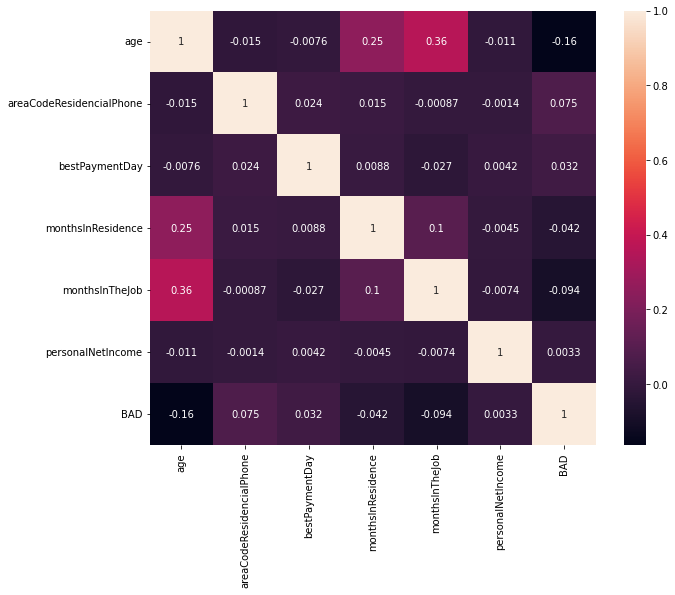

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(clear_data.corr(method='pearson'), annot=True)

Configurando as funções que utilizerei para visualizar os dados

In [ ]:
def limites(coluna):
  q1 = coluna.quantile(0.25)
  q3 = coluna.quantile(0.75)
  amplitude = q3 - q1
  return q1 - 1.5*amplitude, q3 + 1.5*amplitude

In [ ]:
def diagrama_caixa(coluna):
  fig, (ax1,ax2) = plt.subplots(1,2)
  fig.set_size_inches(15,5)
  sns.boxplot(x=coluna, ax=ax1)
  ax2.set_xlim(limites(coluna))
  sns.boxplot(x=coluna, ax=ax2)

In [ ]:
def histograma(coluna):
  plt.figure(figsize=(15,5))
  sns.distplot(coluna, hist=True)

In [ ]:
def grafico_barras(coluna):
  plt.figure(figsize=(15,5))
  plt.xticks(rotation = 90)
  ax = sns.barplot(x = coluna.value_counts().index, y=coluna.value_counts())
  ax.set_xlim(limites(coluna))

In [ ]:
def excluir_outliers(coluna, df):
  quantidade_linhas = df.shape[0]
  limite_inferior, limite_superior = limites(df[coluna])
  df = df.loc[(df[coluna] >= limite_inferior) & (df[coluna]<= limite_superior),:]
  linhas_removidas = quantidade_linhas - df.shape[0]
  return df, linhas_removidas

In [ ]:
dataset = clear_data.copy()

In [ ]:
dataset['BAD'].value_counts()

0    32098
1     7899
Name: BAD, dtype: int64

#### Removendo os outiliers das variáveis quantitativas

### Analisando a variável continua

In [ ]:
dataset['personalNetIncome'].value_counts()
limites(dataset['personalNetIncome'])

(-432.0, 1440.0)

In [ ]:
dataset.loc[dataset['personalNetIncome'] > 1447.5]

,gender,maritalStatus,age,flagResidencialPhone,areaCodeResidencialPhone,bestPaymentDay,residenceType,monthsInResidence,flagResidenceTown_WorkingTown,monthsInTheJob,personalNetIncome,BAD
10,M,C,36,Y,31,12,P,120,Y,36,1987.0,0
19,F,S,46,Y,31,8,A,48,Y,192,3100.0,0
38,M,D,26,N,31,12,P,120,Y,0,2701.0,0
54,F,C,32,Y,31,1,P,96,Y,24,1805.0,0
60,F,C,75,Y,31,8,P,48,N,0,3900.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
39899,M,C,47,N,50,28,P,216,N,216,1500.0,1
39925,M,C,54,Y,31,3,P,240,N,0,7158.0,0
39933,F,C,48,Y,31,8,P,576,N,72,2000.0,0
39943,F,D,41,Y,5,25,P,12,Y,12,1500.0,0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


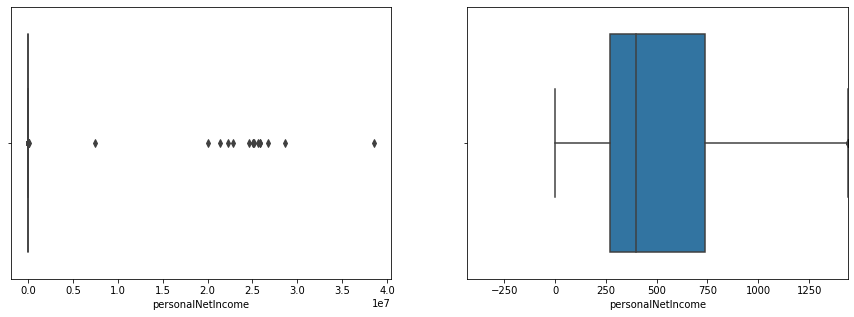

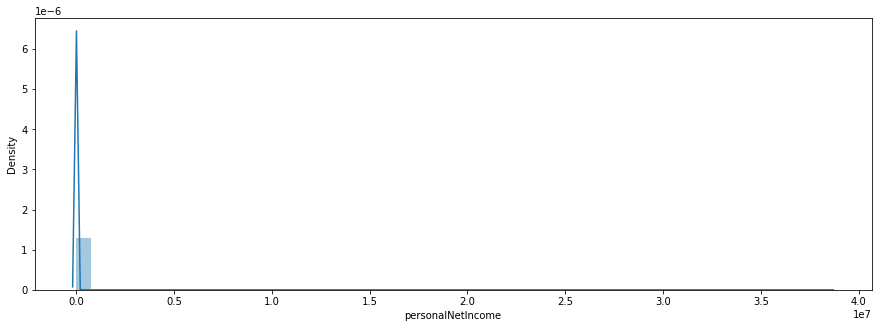

In [ ]:
diagrama_caixa(clear_data['personalNetIncome'])
histograma(clear_data['personalNetIncome'])

In [ ]:
dataset_personalIncome_Bad = dataset[['personalNetIncome','BAD']]
dataset_personalIncome_Bad.loc[(dataset_personalIncome_Bad['BAD']==1) & (dataset_personalIncome_Bad['personalNetIncome']>1476.5)].count()

personalNetIncome    392
BAD                  392
dtype: int64

Pensando no contexto de crédito para o público que geralmente recorre a Mutual, acredito que retirar os Outilieres faça mais sentido, pois, o modelo conseguirá ser mais preciso para o público mais presente na base de dados da Mutual.

Além disso, os valores de __personalNetIncome__ maiores que R$ 1.476,50 representam mais de 3 mil linhas das 40 mil linhas ainda presentes no dataset. Sendo que, 392 dessas linhas representam um cliente inadimplente e que possuem uma renda superior a 1.476,50 Reais.

In [ ]:
dataset, linhas_removidas= excluir_outliers(coluna='personalNetIncome', df=dataset)
print(f"Foram removidas um total de {linhas_removidas} linhas")

Foram removidas um total de 3156 linhas


In [ ]:
dataset['BAD'].value_counts()

0    29341
1     7500
Name: BAD, dtype: int64

### Avaliando variáveis discretas

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36841 entries, 0 to 39999
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   gender                         36841 non-null  object 
 1   maritalStatus                  36841 non-null  object 
 2   age                            36841 non-null  int64  
 3   flagResidencialPhone           36841 non-null  object 
 4   areaCodeResidencialPhone       36841 non-null  int64  
 5   bestPaymentDay                 36841 non-null  int64  
 6   residenceType                  36841 non-null  object 
 7   monthsInResidence              36841 non-null  int64  
 8   flagResidenceTown_WorkingTown  36841 non-null  object 
 9   monthsInTheJob                 36841 non-null  int64  
 10  personalNetIncome              36841 non-null  float64
 11  BAD                            36841 non-null  int64  
dtypes: float64(1), int64(6), object(5)
memory usag

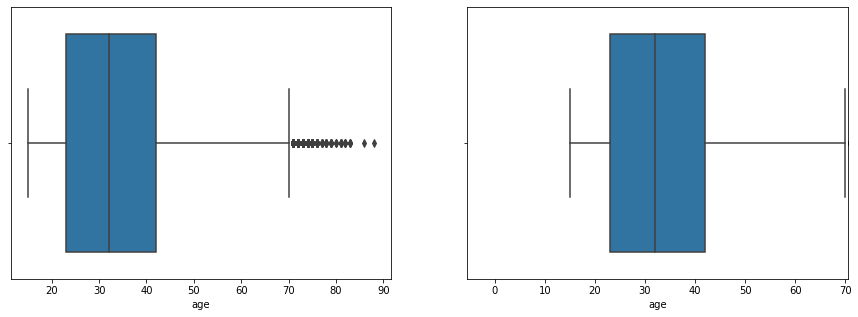

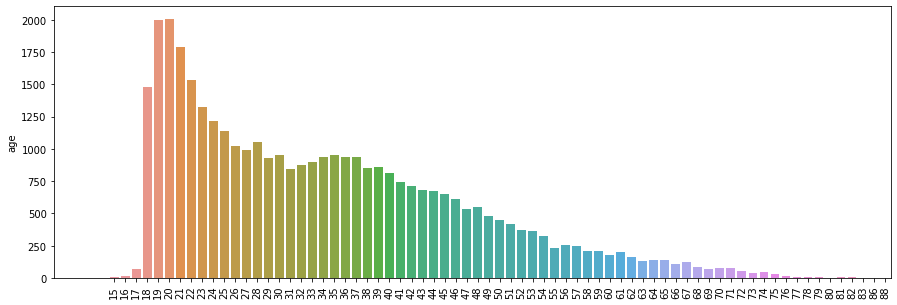

In [ ]:
diagrama_caixa(dataset['age'])
grafico_barras(dataset['age'])

In [ ]:
limites(dataset['age'])

(-5.5, 70.5)

In [ ]:
dataset_age_bad = dataset[['age', 'BAD']]
dataset_age_bad.loc[(dataset_age_bad['BAD']==1) & (dataset_age_bad['age']>70)].count()

age    34
BAD    34
dtype: int64

Analisando os dados de idade é possível perceber que o público alvo está na faixa de 15 a 70 anos de idade. Sendo assim, vou excluir os outliers, até por que são 34 clientes indimplentes em uma base de mais de 7501 pessoas consideradas inadimplentes. O que reprenta 0,45% do total da base de clientes inadimplentes.

In [ ]:
dataset, linhas_removidas = excluir_outliers(coluna='age', df=dataset)
print(f'{linhas_removidas} linhas removidas')

320 linhas removidas


In [ ]:
dataset['BAD'].value_counts()

0    29055
1     7466
Name: BAD, dtype: int64

Coluna areaCodeResidencialPhone

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Attempting to set identical left == right == 31.0 results in singular transformations; automatically expanding.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Attempting to set identical left == right == 31.0 results in singular transformations; automatically expanding.
  """


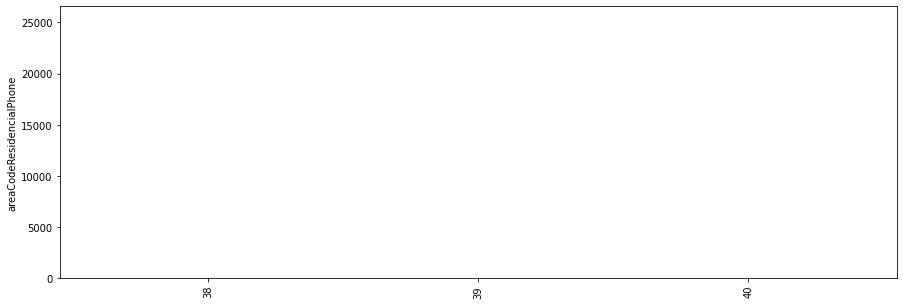

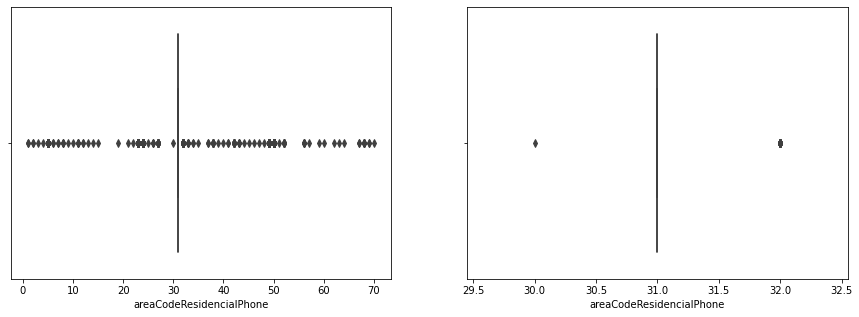

In [ ]:
grafico_barras(dataset['areaCodeResidencialPhone'])
diagrama_caixa(dataset['areaCodeResidencialPhone'])

Analisando esta coluna eu decidi não remover os outiliers devido ser uma coluna de caráter categórico que define inclusive a região em que o cliente pode estar morando. O que pode ser de certa forma importante para o modelo classificar. Além disso, no tratamento dos dados já havia visto que a maior parte dos cliente são de Minas gerais (DDD 31).

Coluna bestPaymentDay

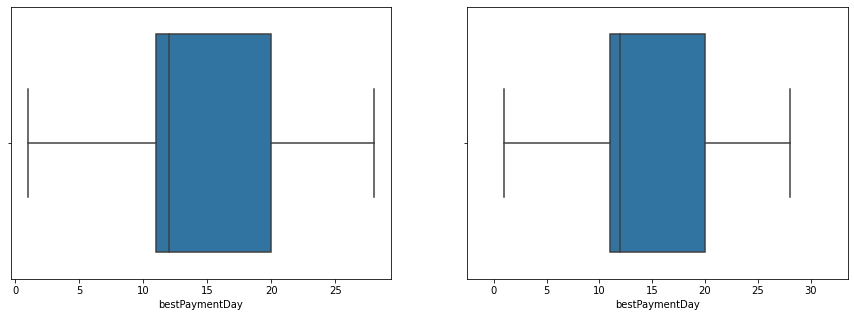

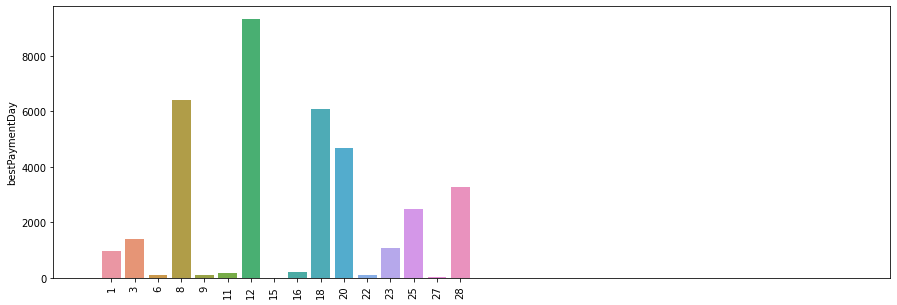

In [ ]:
diagrama_caixa(dataset['bestPaymentDay'])
grafico_barras(dataset['bestPaymentDay'])

Analisando esta coluna pude ver que não há outlieres e que os dados estão dentro do limite calculado. E o dia mais escolhido para pagamento é o dia 12 de cada mês, seguindo do dia 8, 18 e 20.

Coluna monthsInResidence

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


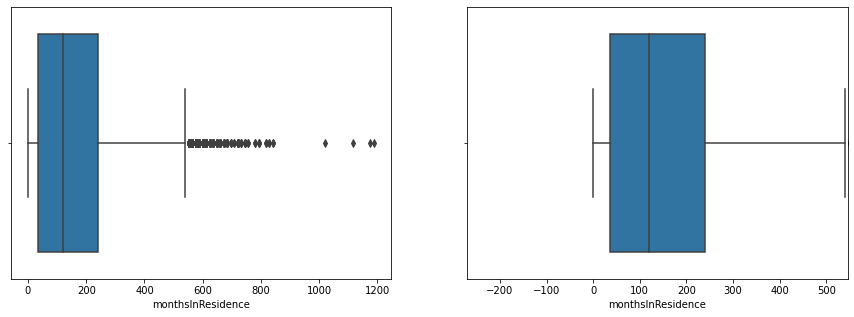

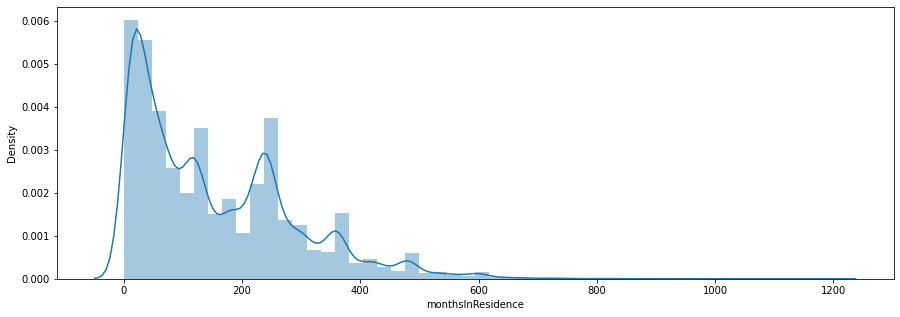

In [ ]:
diagrama_caixa(dataset['monthsInResidence'])
histograma(dataset['monthsInResidence'])

In [ ]:
limites(dataset['monthsInResidence'])

(-270.0, 546.0)

In [ ]:
dataset_time_residence = dataset[['BAD', 'monthsInResidence']]
dataset_time_residence[(dataset_time_residence['BAD']==1) & (dataset_time_residence['monthsInResidence']>546)].count()

BAD                  41
monthsInResidence    41
dtype: int64

In [ ]:
dataset_time_residence['BAD'].value_counts()

0    29055
1     7466
Name: BAD, dtype: int64

No caso dos meses de trabalho vale a pena retirar os dados considerados outliers, devido a serem um pequeno pedaço da base de clientes considerados inadimplentes. 41 clientes em cima de uma base superior a 7466 clientes.

In [ ]:
dataset, linhas_removidas = excluir_outliers(coluna='monthsInResidence', df=dataset)
print(f'{linhas_removidas} linhas removidas')

401 linhas removidas


In [ ]:
dataset['BAD'].value_counts()

0    28695
1     7425
Name: BAD, dtype: int64

Coluna monthsInTheJob

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


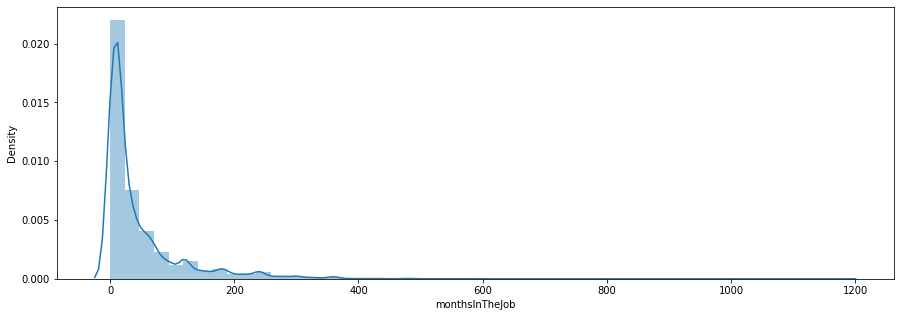

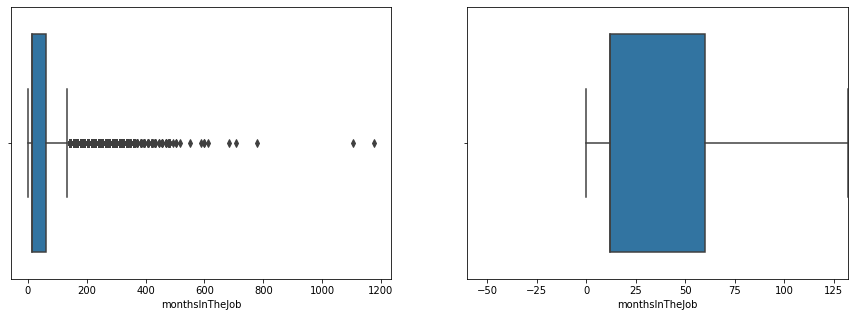

In [ ]:
histograma(dataset['monthsInTheJob'])
diagrama_caixa(dataset['monthsInTheJob'])

In [ ]:
limites(dataset['monthsInTheJob'])

(-60.0, 132.0)

In [ ]:
dataset_moths_job = dataset[['monthsInTheJob','BAD']]
dataset_moths_job[(dataset_moths_job['BAD']==1) & (dataset_moths_job['monthsInTheJob'] >132)].count()

monthsInTheJob    399
BAD               399
dtype: int64

In [ ]:
dataset_moths_job[(dataset_moths_job['monthsInTheJob'] > 132)].count()

monthsInTheJob    3242
BAD               3242
dtype: int64

Nesta coluna, foi um caso sensível. E decidi por permanecer os outliers por alguns motivos. Um deles é que a quantidade de linhas a serem eliminadas ao todo para esse único caso é considerável, no caso, 3242. Além disso, diferente das colunas que os dados eliminados representavam menos de 1% da minha base de inadimplância, neste caso já representa 5% da minha base de inadimplentes.

# 3. Feature Engineering

In [ ]:
dataset_enconding = dataset.copy()

In [ ]:
dataset_enconding.shape

(36120, 12)

In [ ]:
#importando as bibliotecas
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

Convertendo os campos considerados Objects em Numéricos

In [ ]:
dataset_enconding.select_dtypes(include='object').columns

Index(['gender', 'maritalStatus', 'flagResidencialPhone', 'residenceType',
       'flagResidenceTown_WorkingTown'],
      dtype='object')

In [ ]:
dataset_enconding.shape

(36120, 12)

In [ ]:
for label in ['gender', 'maritalStatus', 'flagResidencialPhone', 'residenceType','flagResidenceTown_WorkingTown']:
  dataset_enconding[label] = LabelEncoder().fit_transform(dataset_enconding[label])

Separando as variaveis de entrada do algoritmo em X

In [ ]:
X = dataset_enconding.drop('BAD', axis=1)

Analisando a correlação entre as variáveis após o Enconding. Vi que as colunas __flagResidencialPhone__ e __areaCodeResidencialPhone__ tem uma correlção negativa e que no caso seria interessante realizar mais um tratamento e talvez remover essas colunas da análise.

UsageError: unrecognized arguments: 'inline' )


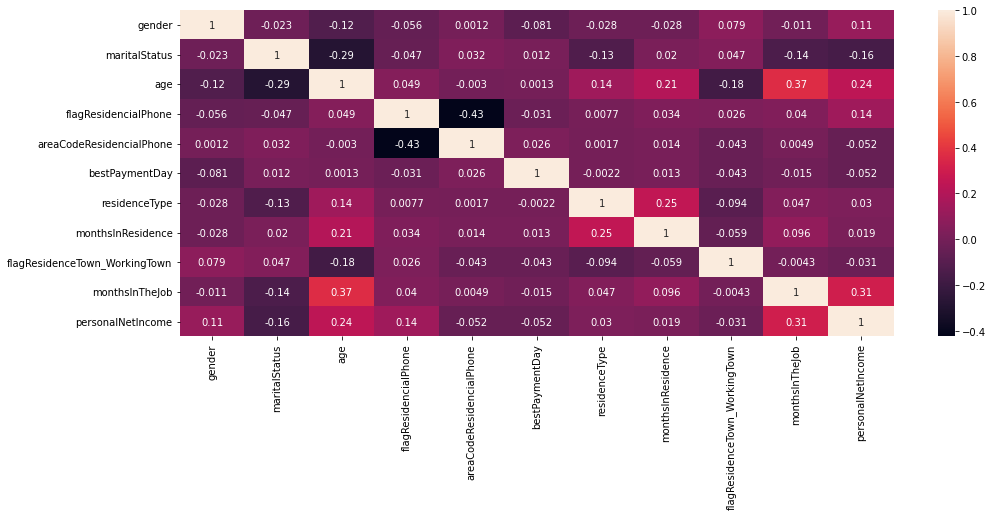

In [ ]:
plt.figure(figsize=(16,6))
sns.heatmap(data=X.corr(), annot=True)
%matplotlib (line= 'inline')

Dividindo a base de Treino e Teste e definindo a variáveis X e Y


In [ ]:
Y = dataset_enconding['BAD'].values.tolist()

In [ ]:
X_train, X_test, Y_train, Y_test =  train_test_split(X,Y, test_size=0.3, stratify=Y, random_state=1)

# 4. Construção de modelos de Machine Learning

Os modelos a serem utilizados serão o Xgboost, RandomForest, ExtraTrees e Logistic Regression

In [ ]:
modelos = {'RandomForest': RandomForestClassifier(n_estimators=1000),"Xgboost":XGBClassifier(n_estimators=2000, learning_rate=0.01),'ExtraTrees': ExtraTreesClassifier(n_estimators=10), 'RegressaoLogistica': LogisticRegression(max_iter=10000)}

In [ ]:
for nome_modelo, modelo in modelos.items():
  #TREINAR
  modelo.fit(X_train, Y_train)
  print(modelo)
  #Testar
  previsao = modelo.predict(X_test)
  #Avaliar
  matriz_confusao = confusion_matrix(previsao, Y_test)
  print(matriz_confusao)
  report_classification = classification_report(previsao, Y_test)
  print(report_classification)
  print("-="*50)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
[[8332 2065]
 [ 276  163]]
              precision    recall  f1-score   support

           0       0.97      0.80      0.88     10397
           1       0.07      0.37      0.12       439

    accuracy                           0.78     10836
   macro avg       0.52      0.59      0.50     10836
weighted avg       0.93      0.78      0.85     10836

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

# 5. Avaliação de Resultados do Modelo

Avaliandos os resultados do nosso modelo pude perceber que ele é muito bom para saber se um cliente é não inadimplente, mas para classificar inadimplência ele não foi nem um pouco efetivo com uma precisão baixissíma e com uma revocação abaixo de 50% nos três modelos. Pude perceber pelo support que o conjunto de dados está desbalanceado, então a quantidade de informações de clientes não inadimplentes é maior que o conjunto de dados de clientes inadimplentes.

Sendo assim, eu irei remover aquelas features com correlação negativa. Features: __flagResidencialPhone__ e __areaCodeResidencialPhone__. Para verificar se há alguma melhora e também irei rebalancear a quantidade de amostras.

In [ ]:
dataset_com_features_removidas = dataset_enconding.copy()

In [ ]:
dataset_com_features_removidas.drop(['flagResidencialPhone','areaCodeResidencialPhone'], axis=1, inplace=True)

In [ ]:
dataset_com_features_removidas.shape

(36120, 10)

In [ ]:
X = dataset_com_features_removidas.drop('BAD', axis=1)

In [ ]:
Y = dataset_com_features_removidas['BAD'].values.tolist()

Após a remoção das features vou realizar o balanceamento dos dados com o __NearMiss__ e o __SMOTE__

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
nearmiss = NearMiss()

In [ ]:
X,Y = nearmiss.fit_sample(X,Y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Foram selecionadas 7.000 linhas para o support do modelo dividir em treino e teste

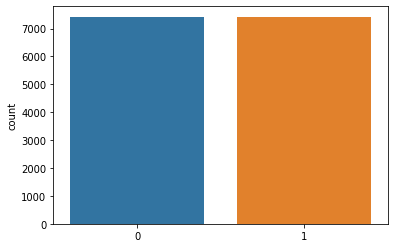

In [ ]:
ax = sns.countplot(x=Y)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1, stratify=Y)

No caso eu obtive uma melhora significativa na precisão de clientes inadimplentes, principalmente para o modelo XGBoost, onde tive um f1-score melhor e uma acuracia próxima do que já tínhamos no começo.

In [ ]:
for nome_modelo, modelo in modelos.items():
  #TREINAR
  modelo.fit(X_train, Y_train)
  print(modelo)
  #Testar
  previsao = modelo.predict(X_test)
  #Avaliar
  matriz_confusao = confusion_matrix(previsao, Y_test)
  print(matriz_confusao)
  report_classification = classification_report(previsao, Y_test)
  print(report_classification)
  print("-="*50)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
[[1383  721]
 [ 473 1136]]
              precision    recall  f1-score   support

           0       0.75      0.66      0.70      2104
           1       0.61      0.71      0.66      1609

    accuracy                           0.68      3713
   macro avg       0.68      0.68      0.68      3713
weighted avg       0.69      0.68      0.68      3713

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

Exportando o modelo para formato .dat utilizando a biblioteca Pickle

In [ ]:
import pickle
pickle.dump(modelos['Xgboost'], open("inadimplencia.pickle.dat", "wb"))

Carregando o modelo exportado

In [ ]:
loaded_model = pickle.load(open("inadimplencia.pickle.dat", "rb"))

### Balanceando os dados com SMOTE

In [ ]:
X = dataset_com_features_removidas.drop('BAD', axis=1)
Y = dataset_com_features_removidas['BAD'].values.tolist()
#Quantidade de dados por classe

np.bincount(Y)

array([28695,  7425])

In [ ]:
#SMOTE
smt = SMOTE()
X,Y = smt.fit_sample(X,Y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
np.bincount(Y)

array([28695, 28695])

O __SMOTE__ ele clonou os dados de forma aleatória para complementar os dados de clientes inadimplentes para se igualar com a quantidade de cleintes não inadimplentes

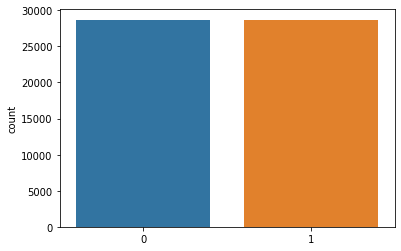

In [ ]:
ax = sns.countplot(x=Y)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1, stratify=Y)

No modelo com SMOTE pode ter um problema de Overfitting, uma vez que ele replica de forma aleatória os dados da variável minoritária. Sendo assim, o modelo pode se ajustar demais aos dados do dataset e não ir tão bem em caso reais e fora do dataset.

In [ ]:
for nome_modelo, modelo in modelos.items():
  #TREINAR
  modelo.fit(X_train, Y_train)
  print(modelo)
  #Testar
  previsao = modelo.predict(X_test)
  #Avaliar
  matriz_confusao = confusion_matrix(previsao, Y_test)
  print(matriz_confusao)
  report_classification = classification_report(previsao, Y_test)
  print(report_classification)
  print("-="*50)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
[[6770 1603]
 [ 404 5571]]
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      8373
           1       0.78      0.93      0.85      5975

    accuracy                           0.86     14348
   macro avg       0.86      0.87      0.86     14348
weighted avg       0.87      0.86      0.86     14348

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

Exportando o modelo

In [ ]:
pickle.dump(modelos['Xgboost'], open("InadimplenciaSMOTE.pickle.dat", "wb"))

Carregando o modelo Exportado

In [ ]:
loaded_model2 = pickle.load(open("InadimplenciaSMOTE.pickle.dat", "rb"))